In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/melting-point/sample_submission.csv
/kaggle/input/melting-point/train.csv
/kaggle/input/melting-point/test.csv


In [2]:
# Modern visualization theme
plt.rcParams['figure.facecolor'] = '#0d1117'
plt.rcParams['axes.facecolor'] = '#161b22'
plt.rcParams['axes.edgecolor'] = '#30363d'
plt.rcParams['grid.color'] = '#21262d'
plt.rcParams['text.color'] = '#c9d1d9'
plt.rcParams['axes.labelcolor'] = '#c9d1d9'
plt.rcParams['xtick.color'] = '#8b949e'
plt.rcParams['ytick.color'] = '#8b949e'
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'sans-serif'

# Custom gradient palette
violet_gradient = ['#7b2cbf', '#9d4edd', '#c77dff', '#e0aaff', '#f72585', '#ff006e']
sns.set_palette(violet_gradient)

## Predicting Melting Points of Organic Compounds Using Machine Learning

## 📘 Project Description 

This project focuses on building machine learning models to estimate the melting point (Tm) of organic molecules in Kelvin using high-dimensional molecular descriptors. By analyzing correlations and training multiple regression algorithms—including Linear Models, Tree-Based Models, and Gradient Boosting methods—the goal is to accurately predict thermophysical properties from structural features. Feature selection, model comparison, and performance evaluation are applied to identify the best predictive approach for molecular melting behavior.

## Load dataset

In [3]:
# Read training and test data
train_df = pd.read_csv("/kaggle/input/melting-point/train.csv")
test_df = pd.read_csv("/kaggle/input/melting-point/test.csv")

# Identify target variable
target_col = train_df.columns.tolist()[-1]

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
train_df.head()

Training data shape: (2662, 427)
Test data shape: (666, 426)


,id,SMILES,Tm,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,Group 8,Group 9,Group 10,Group 11,Group 12,Group 13,Group 14,Group 15,Group 16,Group 17,Group 18,Group 19,Group 20,Group 21,Group 22,Group 23,Group 24,Group 25,Group 26,Group 27,Group 28,Group 29,Group 30,Group 31,Group 32,Group 33,Group 34,Group 35,Group 36,Group 37,Group 38,Group 39,Group 40,Group 41,Group 42,Group 43,Group 44,Group 45,Group 46,Group 47,Group 48,Group 49,Group 50,Group 51,Group 52,Group 53,Group 54,Group 55,Group 56,Group 57,Group 58,Group 59,Group 60,Group 61,Group 62,Group 63,Group 64,Group 65,Group 66,Group 67,Group 68,Group 69,Group 70,Group 71,Group 72,Group 73,Group 74,Group 75,Group 76,Group 77,Group 78,Group 79,Group 80,Group 81,Group 82,Group 83,Group 84,Group 85,Group 86,Group 87,Group 88,Group 89,Group 90,Group 91,Group 92,Group 93,Group 94,Group 95,Group 96,Group 97,Group 98,Group 99,Group 100,Group 101,Group 102,Group 103,Group 104,Group 105,Group 106,Group 107,Group 108,Group 109,Group 110,Group 111,Group 112,Group 113,Group 114,Group 115,Group 116,Group 117,Group 118,Group 119,Group 120,Group 121,Group 122,Group 123,Group 124,Group 125,Group 126,Group 127,Group 128,Group 129,Group 130,Group 131,Group 132,Group 133,Group 134,Group 135,Group 136,Group 137,Group 138,Group 139,Group 140,Group 141,Group 142,Group 143,Group 144,Group 145,Group 146,Group 147,Group 148,Group 149,Group 150,Group 151,Group 152,Group 153,Group 154,Group 155,Group 156,Group 157,Group 158,Group 159,Group 160,Group 161,Group 162,Group 163,Group 164,Group 165,Group 166,Group 167,Group 168,Group 169,Group 170,Group 171,Group 172,Group 173,Group 174,Group 175,Group 176,Group 177,Group 178,Group 179,Group 180,Group 181,Group 182,Group 183,Group 184,Group 185,Group 186,Group 187,Group 188,Group 189,Group 190,Group 191,Group 192,Group 193,Group 194,Group 195,Group 196,Group 197,Group 198,Group 199,Group 200,Group 201,Group 202,Group 203,Group 204,Group 205,Group 206,Group 207,Group 208,Group 209,Group 210,Group 211,Group 212,Group 213,Group 214,Group 215,Group 216,Group 217,Group 218,Group 219,Group 220,Group 221,Group 222,Group 223,Group 224,Group 225,Group 226,Group 227,Group 228,Group 229,Group 230,Group 231,Group 232,Group 233,Group 234,Group 235,Group 236,Group 237,Group 238,Group 239,Group 240,Group 241,Group 242,Group 243,Group 244,Group 245,Group 246,Group 247,Group 248,Group 249,Group 250,Group 251,Group 252,Group 253,Group 254,Group 255,Group 256,Group 257,Group 258,Group 259,Group 260,Group 261,Group 262,Group 263,Group 264,Group 265,Group 266,Group 267,Group 268,Group 269,Group 270,Group 271,Group 272,Group 273,Group 274,Group 275,Group 276,Group 277,Group 278,Group 279,Group 280,Group 281,Group 282,Group 283,Group 284,Group 285,Group 286,Group 287,Group 288,Group 289,Group 290,Group 291,Group 292,Group 293,Group 294,Group 295,Group 296,Group 297,Group 298,Group 299,Group 300,Group 301,Group 302,Group 303,Group 304,Group 305,Group 306,Group 307,Group 308,Group 309,Group 310,Group 311,Group 312,Group 313,Group 314,Group 315,Group 316,Group 317,Group 318,Group 319,Group 320,Group 321,Group 322,Group 323,Group 324,Group 325,Group 326,Group 327,Group 328,Group 329,Group 330,Group 331,Group 332,Group 333,Group 334,Group 335,Group 336,Group 337,Group 338,Group 339,Group 340,Group 341,Group 342,Group 343,Group 344,Group 345,Group 346,Group 347,Group 348,Group 349,Group 350,Group 351,Group 352,Group 353,Group 354,Group 355,Group 356,Group 357,Group 358,Group 359,Group 360,Group 361,Group 362,Group 363,Group 364,Group 365,Group 366,Group 367,Group 368,Group 369,Group 370,Group 371,Group 372,Group 373,Group 374,Group 375,Group 376,Group 377,Group 378,Group 379,Group 380,Group 381,Group 382,Group 383,Group 384,Group 385,Group 386,Group 387,Group 388,Group 389,Group 390,Group 391,Group 392,Group 393,Group 394,Group 395,Group 396,Group 397,Group 398,Group 399,Group 400,Group 401,Group 402,Group 403,Group 404,Group 405,Group 406,Group 407,Group 408,Group 409,Grou

## EDA

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2662 entries, 0 to 2661
Columns: 427 entries, id to Group 424
dtypes: float64(1), int64(425), object(1)
memory usage: 8.7+ MB


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666 entries, 0 to 665
Columns: 426 entries, id to Group 424
dtypes: int64(425), object(1)
memory usage: 2.2+ MB


In [6]:
train_df.describe()

,id,Tm,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,Group 8,Group 9,Group 10,Group 11,Group 12,Group 13,Group 14,Group 15,Group 16,Group 17,Group 18,Group 19,Group 20,Group 21,Group 22,Group 23,Group 24,Group 25,Group 26,Group 27,Group 28,Group 29,Group 30,Group 31,Group 32,Group 33,Group 34,Group 35,Group 36,Group 37,Group 38,Group 39,Group 40,Group 41,Group 42,Group 43,Group 44,Group 45,Group 46,Group 47,Group 48,Group 49,Group 50,Group 51,Group 52,Group 53,Group 54,Group 55,Group 56,Group 57,Group 58,Group 59,Group 60,Group 61,Group 62,Group 63,Group 64,Group 65,Group 66,Group 67,Group 68,Group 69,Group 70,Group 71,Group 72,Group 73,Group 74,Group 75,Group 76,Group 77,Group 78,Group 79,Group 80,Group 81,Group 82,Group 83,Group 84,Group 85,Group 86,Group 87,Group 88,Group 89,Group 90,Group 91,Group 92,Group 93,Group 94,Group 95,Group 96,Group 97,Group 98,Group 99,Group 100,Group 101,Group 102,Group 103,Group 104,Group 105,Group 106,Group 107,Group 108,Group 109,Group 110,Group 111,Group 112,Group 113,Group 114,Group 115,Group 116,Group 117,Group 118,Group 119,Group 120,Group 121,Group 122,Group 123,Group 124,Group 125,Group 126,Group 127,Group 128,Group 129,Group 130,Group 131,Group 132,Group 133,Group 134,Group 135,Group 136,Group 137,Group 138,Group 139,Group 140,Group 141,Group 142,Group 143,Group 144,Group 145,Group 146,Group 147,Group 148,Group 149,Group 150,Group 151,Group 152,Group 153,Group 154,Group 155,Group 156,Group 157,Group 158,Group 159,Group 160,Group 161,Group 162,Group 163,Group 164,Group 165,Group 166,Group 167,Group 168,Group 169,Group 170,Group 171,Group 172,Group 173,Group 174,Group 175,Group 176,Group 177,Group 178,Group 179,Group 180,Group 181,Group 182,Group 183,Group 184,Group 185,Group 186,Group 187,Group 188,Group 189,Group 190,Group 191,Group 192,Group 193,Group 194,Group 195,Group 196,Group 197,Group 198,Group 199,Group 200,Group 201,Group 202,Group 203,Group 204,Group 205,Group 206,Group 207,Group 208,Group 209,Group 210,Group 211,Group 212,Group 213,Group 214,Group 215,Group 216,Group 217,Group 218,Group 219,Group 220,Group 221,Group 222,Group 223,Group 224,Group 225,Group 226,Group 227,Group 228,Group 229,Group 230,Group 231,Group 232,Group 233,Group 234,Group 235,Group 236,Group 237,Group 238,Group 239,Group 240,Group 241,Group 242,Group 243,Group 244,Group 245,Group 246,Group 247,Group 248,Group 249,Group 250,Group 251,Group 252,Group 253,Group 254,Group 255,Group 256,Group 257,Group 258,Group 259,Group 260,Group 261,Group 262,Group 263,Group 264,Group 265,Group 266,Group 267,Group 268,Group 269,Group 270,Group 271,Group 272,Group 273,Group 274,Group 275,Group 276,Group 277,Group 278,Group 279,Group 280,Group 281,Group 282,Group 283,Group 284,Group 285,Group 286,Group 287,Group 288,Group 289,Group 290,Group 291,Group 292,Group 293,Group 294,Group 295,Group 296,Group 297,Group 298,Group 299,Group 300,Group 301,Group 302,Group 303,Group 304,Group 305,Group 306,Group 307,Group 308,Group 309,Group 310,Group 311,Group 312,Group 313,Group 314,Group 315,Group 316,Group 317,Group 318,Group 319,Group 320,Group 321,Group 322,Group 323,Group 324,Group 325,Group 326,Group 327,Group 328,Group 329,Group 330,Group 331,Group 332,Group 333,Group 334,Group 335,Group 336,Group 337,Group 338,Group 339,Group 340,Group 341,Group 342,Group 343,Group 344,Group 345,Group 346,Group 347,Group 348,Group 349,Group 350,Group 351,Group 352,Group 353,Group 354,Group 355,Group 356,Group 357,Group 358,Group 359,Group 360,Group 361,Group 362,Group 363,Group 364,Group 365,Group 366,Group 367,Group 368,Group 369,Group 370,Group 371,Group 372,Group 373,Group 374,Group 375,Group 376,Group 377,Group 378,Group 379,Group 380,Group 381,Group 382,Group 383,Group 384,Group 385,Group 386,Group 387,Group 388,Group 389,Group 390,Group 391,Group 392,Group 393,Group 394,Group 395,Group 396,Group 397,Group 398,Group 399,Group 400,Group 401,Group 402,Group 403,Group 404,Group 405,Group 406,Group 407,Group 408,Group 409,Group 410,G

In [7]:
train_df.isnull().sum()

id           0
SMILES       0
Tm           0
Group 1      0
Group 2      0
            ..
Group 420    0
Group 421    0
Group 422    0
Group 423    0
Group 424    0
Length: 427, dtype: int64

In [8]:
train_df.duplicated().sum()

0

In [9]:
train_df.dtypes

id             int64
SMILES        object
Tm           float64
Group 1        int64
Group 2        int64
              ...   
Group 420      int64
Group 421      int64
Group 422      int64
Group 423      int64
Group 424      int64
Length: 427, dtype: object

In [10]:
train_df.shape

(2662, 427)

In [11]:
print("Trains columns :")
print(train_df.columns.tolist())

print("\nDescrib num columns:")
display(train_df.describe())

print("\nMissing values (train) :")
print(train_df.isna().sum())

print("\nMissing values (test) :")
print(test_df.isna().sum())

Trains columns :
['id', 'SMILES', 'Tm', 'Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5', 'Group 6', 'Group 7', 'Group 8', 'Group 9', 'Group 10', 'Group 11', 'Group 12', 'Group 13', 'Group 14', 'Group 15', 'Group 16', 'Group 17', 'Group 18', 'Group 19', 'Group 20', 'Group 21', 'Group 22', 'Group 23', 'Group 24', 'Group 25', 'Group 26', 'Group 27', 'Group 28', 'Group 29', 'Group 30', 'Group 31', 'Group 32', 'Group 33', 'Group 34', 'Group 35', 'Group 36', 'Group 37', 'Group 38', 'Group 39', 'Group 40', 'Group 41', 'Group 42', 'Group 43', 'Group 44', 'Group 45', 'Group 46', 'Group 47', 'Group 48', 'Group 49', 'Group 50', 'Group 51', 'Group 52', 'Group 53', 'Group 54', 'Group 55', 'Group 56', 'Group 57', 'Group 58', 'Group 59', 'Group 60', 'Group 61', 'Group 62', 'Group 63', 'Group 64', 'Group 65', 'Group 66', 'Group 67', 'Group 68', 'Group 69', 'Group 70', 'Group 71', 'Group 72', 'Group 73', 'Group 74', 'Group 75', 'Group 76', 'Group 77', 'Group 78', 'Group 79', 'Group 80', 'Group 81

,id,Tm,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,Group 8,Group 9,Group 10,Group 11,Group 12,Group 13,Group 14,Group 15,Group 16,Group 17,Group 18,Group 19,Group 20,Group 21,Group 22,Group 23,Group 24,Group 25,Group 26,Group 27,Group 28,Group 29,Group 30,Group 31,Group 32,Group 33,Group 34,Group 35,Group 36,Group 37,Group 38,Group 39,Group 40,Group 41,Group 42,Group 43,Group 44,Group 45,Group 46,Group 47,Group 48,Group 49,Group 50,Group 51,Group 52,Group 53,Group 54,Group 55,Group 56,Group 57,Group 58,Group 59,Group 60,Group 61,Group 62,Group 63,Group 64,Group 65,Group 66,Group 67,Group 68,Group 69,Group 70,Group 71,Group 72,Group 73,Group 74,Group 75,Group 76,Group 77,Group 78,Group 79,Group 80,Group 81,Group 82,Group 83,Group 84,Group 85,Group 86,Group 87,Group 88,Group 89,Group 90,Group 91,Group 92,Group 93,Group 94,Group 95,Group 96,Group 97,Group 98,Group 99,Group 100,Group 101,Group 102,Group 103,Group 104,Group 105,Group 106,Group 107,Group 108,Group 109,Group 110,Group 111,Group 112,Group 113,Group 114,Group 115,Group 116,Group 117,Group 118,Group 119,Group 120,Group 121,Group 122,Group 123,Group 124,Group 125,Group 126,Group 127,Group 128,Group 129,Group 130,Group 131,Group 132,Group 133,Group 134,Group 135,Group 136,Group 137,Group 138,Group 139,Group 140,Group 141,Group 142,Group 143,Group 144,Group 145,Group 146,Group 147,Group 148,Group 149,Group 150,Group 151,Group 152,Group 153,Group 154,Group 155,Group 156,Group 157,Group 158,Group 159,Group 160,Group 161,Group 162,Group 163,Group 164,Group 165,Group 166,Group 167,Group 168,Group 169,Group 170,Group 171,Group 172,Group 173,Group 174,Group 175,Group 176,Group 177,Group 178,Group 179,Group 180,Group 181,Group 182,Group 183,Group 184,Group 185,Group 186,Group 187,Group 188,Group 189,Group 190,Group 191,Group 192,Group 193,Group 194,Group 195,Group 196,Group 197,Group 198,Group 199,Group 200,Group 201,Group 202,Group 203,Group 204,Group 205,Group 206,Group 207,Group 208,Group 209,Group 210,Group 211,Group 212,Group 213,Group 214,Group 215,Group 216,Group 217,Group 218,Group 219,Group 220,Group 221,Group 222,Group 223,Group 224,Group 225,Group 226,Group 227,Group 228,Group 229,Group 230,Group 231,Group 232,Group 233,Group 234,Group 235,Group 236,Group 237,Group 238,Group 239,Group 240,Group 241,Group 242,Group 243,Group 244,Group 245,Group 246,Group 247,Group 248,Group 249,Group 250,Group 251,Group 252,Group 253,Group 254,Group 255,Group 256,Group 257,Group 258,Group 259,Group 260,Group 261,Group 262,Group 263,Group 264,Group 265,Group 266,Group 267,Group 268,Group 269,Group 270,Group 271,Group 272,Group 273,Group 274,Group 275,Group 276,Group 277,Group 278,Group 279,Group 280,Group 281,Group 282,Group 283,Group 284,Group 285,Group 286,Group 287,Group 288,Group 289,Group 290,Group 291,Group 292,Group 293,Group 294,Group 295,Group 296,Group 297,Group 298,Group 299,Group 300,Group 301,Group 302,Group 303,Group 304,Group 305,Group 306,Group 307,Group 308,Group 309,Group 310,Group 311,Group 312,Group 313,Group 314,Group 315,Group 316,Group 317,Group 318,Group 319,Group 320,Group 321,Group 322,Group 323,Group 324,Group 325,Group 326,Group 327,Group 328,Group 329,Group 330,Group 331,Group 332,Group 333,Group 334,Group 335,Group 336,Group 337,Group 338,Group 339,Group 340,Group 341,Group 342,Group 343,Group 344,Group 345,Group 346,Group 347,Group 348,Group 349,Group 350,Group 351,Group 352,Group 353,Group 354,Group 355,Group 356,Group 357,Group 358,Group 359,Group 360,Group 361,Group 362,Group 363,Group 364,Group 365,Group 366,Group 367,Group 368,Group 369,Group 370,Group 371,Group 372,Group 373,Group 374,Group 375,Group 376,Group 377,Group 378,Group 379,Group 380,Group 381,Group 382,Group 383,Group 384,Group 385,Group 386,Group 387,Group 388,Group 389,Group 390,Group 391,Group 392,Group 393,Group 394,Group 395,Group 396,Group 397,Group 398,Group 399,Group 400,Group 401,Group 402,Group 403,Group 404,Group 405,Group 406,Group 407,Group 408,Group 409,Group 410,G


Missing values (train) :
id           0
SMILES       0
Tm           0
Group 1      0
Group 2      0
            ..
Group 420    0
Group 421    0
Group 422    0
Group 423    0
Group 424    0
Length: 427, dtype: int64

Missing values (test) :
id           0
SMILES       0
Group 1      0
Group 2      0
Group 3      0
            ..
Group 420    0
Group 421    0
Group 422    0
Group 423    0
Group 424    0
Length: 426, dtype: int64


In [12]:
train_df.nunique()

id           2662
SMILES       2662
Tm           1195
Group 1        13
Group 2        35
             ... 
Group 420       1
Group 421       1
Group 422       1
Group 423       1
Group 424       1
Length: 427, dtype: int64

In [13]:
print(len(train_df.columns))

427


In [14]:
col_drop = []

for col in train_df.columns:
    if len(train_df[col].unique()) == 1:
        train_df.drop(col, axis=1, inplace=True)
        col_drop.append(col)

In [15]:
print(len(train_df.columns))

340


In [16]:
print("Columns other than int or float\n")

for cols in train_df.columns:
    if train_df[cols].dtype not in ['float64', 'int64']:
        print(cols, " - ", train_df[cols].dtype, " - ", len(train_df[cols].unique()))

Columns other than int or float

SMILES  -  object  -  2662


In [17]:
train_df.drop("SMILES", axis=1, inplace=True)

In [18]:
train_df.describe()

,id,Tm,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,Group 8,Group 9,Group 10,Group 11,Group 13,Group 14,Group 15,Group 16,Group 17,Group 18,Group 19,Group 20,Group 21,Group 22,Group 23,Group 24,Group 25,Group 26,Group 27,Group 29,Group 30,Group 31,Group 32,Group 33,Group 34,Group 35,Group 36,Group 37,Group 38,Group 39,Group 40,Group 41,Group 42,Group 43,Group 44,Group 45,Group 47,Group 48,Group 49,Group 50,Group 51,Group 52,Group 53,Group 54,Group 55,Group 56,Group 57,Group 58,Group 59,Group 60,Group 61,Group 62,Group 63,Group 64,Group 65,Group 66,Group 68,Group 69,Group 70,Group 71,Group 72,Group 76,Group 77,Group 78,Group 79,Group 80,Group 81,Group 82,Group 83,Group 86,Group 87,Group 89,Group 91,Group 92,Group 93,Group 94,Group 95,Group 96,Group 97,Group 98,Group 99,Group 100,Group 103,Group 105,Group 106,Group 107,Group 108,Group 109,Group 110,Group 111,Group 112,Group 113,Group 114,Group 115,Group 116,Group 117,Group 118,Group 119,Group 120,Group 121,Group 122,Group 123,Group 124,Group 125,Group 126,Group 127,Group 128,Group 129,Group 130,Group 131,Group 132,Group 133,Group 134,Group 135,Group 136,Group 137,Group 138,Group 139,Group 140,Group 141,Group 142,Group 143,Group 144,Group 145,Group 146,Group 147,Group 148,Group 149,Group 151,Group 153,Group 154,Group 156,Group 157,Group 159,Group 161,Group 162,Group 163,Group 164,Group 165,Group 166,Group 168,Group 169,Group 170,Group 171,Group 172,Group 173,Group 174,Group 175,Group 176,Group 177,Group 178,Group 179,Group 180,Group 181,Group 182,Group 184,Group 185,Group 186,Group 187,Group 188,Group 189,Group 190,Group 191,Group 192,Group 193,Group 195,Group 196,Group 197,Group 199,Group 200,Group 201,Group 202,Group 203,Group 204,Group 205,Group 210,Group 211,Group 219,Group 220,Group 221,Group 222,Group 223,Group 224,Group 225,Group 226,Group 227,Group 228,Group 229,Group 230,Group 231,Group 232,Group 233,Group 234,Group 235,Group 236,Group 237,Group 238,Group 239,Group 240,Group 241,Group 242,Group 243,Group 244,Group 246,Group 249,Group 251,Group 254,Group 255,Group 256,Group 257,Group 258,Group 259,Group 260,Group 261,Group 262,Group 263,Group 265,Group 266,Group 267,Group 268,Group 269,Group 270,Group 271,Group 272,Group 273,Group 274,Group 275,Group 276,Group 277,Group 278,Group 279,Group 283,Group 284,Group 286,Group 287,Group 288,Group 289,Group 290,Group 291,Group 292,Group 293,Group 295,Group 296,Group 297,Group 298,Group 299,Group 300,Group 301,Group 302,Group 304,Group 305,Group 310,Group 311,Group 314,Group 315,Group 318,Group 319,Group 320,Group 321,Group 322,Group 323,Group 324,Group 325,Group 326,Group 327,Group 328,Group 329,Group 330,Group 331,Group 332,Group 333,Group 334,Group 335,Group 336,Group 337,Group 338,Group 339,Group 341,Group 343,Group 344,Group 346,Group 351,Group 353,Group 354,Group 359,Group 361,Group 362,Group 364,Group 365,Group 366,Group 367,Group 368,Group 369,Group 370,Group 372,Group 373,Group 374,Group 375,Group 378,Group 379,Group 380,Group 381,Group 382,Group 386,Group 387,Group 388,Group 389,Group 391,Group 392,Group 393,Group 394,Group 395,Group 396,Group 398,Group 400,Group 401,Group 402,Group 403,Group 404,Group 405,Group 406,Group 407,Group 408,Group 409,Group 410,Group 412,Group 414,Group 415,Group 416,Group 418
count,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2.662e+03,2.662e+03,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2.662e+03,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2.662e+03,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2.662e+03,2.662e+03,2662.000,2662.000,2.662e+03,2662.000,2662.

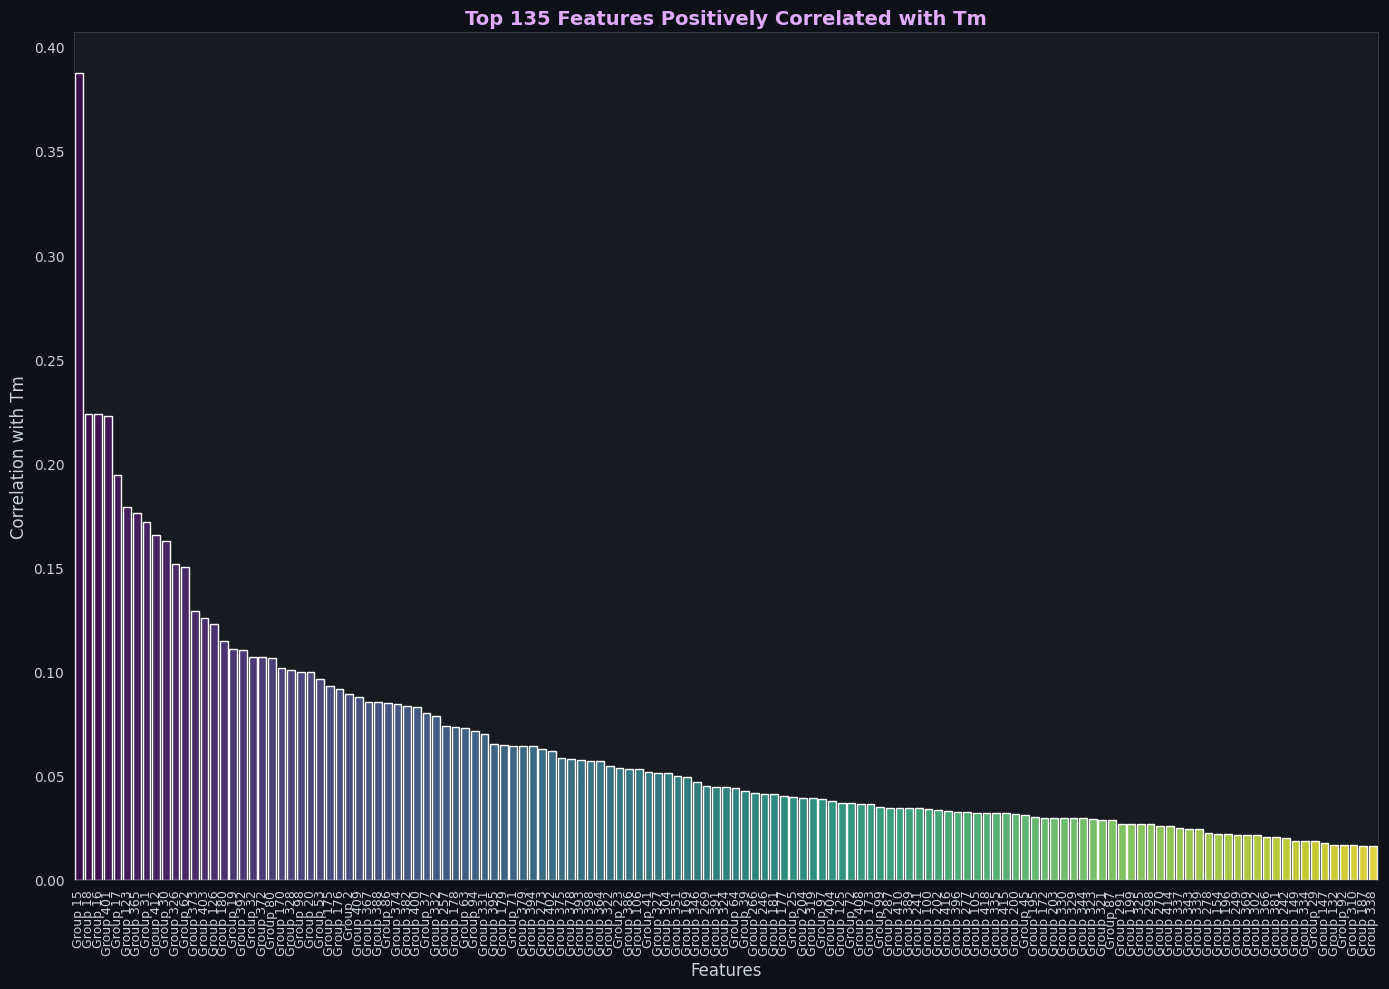


Top 135 Features selected:
['Group 15', 'Group 18', 'Group 16', 'Group 401', 'Group 17', 'Group 123', 'Group 365', 'Group 31', 'Group 412', 'Group 30', 'Group 326', 'Group 62', 'Group 373', 'Group 403', 'Group 126', 'Group 180', 'Group 19', 'Group 392', 'Group 32', 'Group 372', 'Group 80', 'Group 170', 'Group 328', 'Group 98', 'Group 20', 'Group 53', 'Group 175', 'Group 176', 'Group 2', 'Group 409', 'Group 367', 'Group 388', 'Group 86', 'Group 374', 'Group 382', 'Group 400', 'Group 37', 'Group 332', 'Group 257', 'Group 178', 'Group 63', 'Group 94', 'Group 331', 'Group 395', 'Group 179', 'Group 71', 'Group 379', 'Group 394', 'Group 273', 'Group 402', 'Group 375', 'Group 378', 'Group 393', 'Group 398', 'Group 364', 'Group 322', 'Group 23', 'Group 386', 'Group 106', 'Group 41', 'Group 327', 'Group 304', 'Group 351', 'Group 169', 'Group 346', 'Group 269', 'Group 391', 'Group 324', 'Group 64', 'Group 39', 'Group 266', 'Group 246', 'Group 181', 'Group 177', 'Group 25', 'Group 204', 'Group 3

In [19]:
corr = (
    train_df.corr(numeric_only=True)['Tm']
      .sort_values(ascending=False)
      .reset_index()
)

corr.columns = ['Features', 'Corr_with_Tm']

# Remove Tm itself (first row)
corr = corr[corr['Features'] != 'Tm']
k = 135     # choose any value
top_k = corr.head(k)

# Create subset DataFrame
topk_df = train_df[top_k['Features'].tolist() + ['Tm']]
plt.figure(figsize=(14, 10), facecolor="#0d1117")

sns.barplot(
    data=top_k,
    x='Features',
    y='Corr_with_Tm',
    palette='viridis'
)

plt.xticks(rotation=90, fontsize=9, color="#c9d1d9")
plt.yticks(color="#c9d1d9")

plt.title(
    f"Top {k} Features Positively Correlated with Tm",
    fontsize=14, color="#e0aaff", weight='600'
)

plt.xlabel("Features", fontsize=12, color="#c9d1d9")
plt.ylabel("Correlation with Tm", fontsize=12, color="#c9d1d9")

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()
print(f"\nTop {k} Features selected:")
print(top_k['Features'].tolist())


## ML Algorithms

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

# ML Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [21]:
X = topk_df.drop('Tm', axis=1)
y = topk_df['Tm']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [22]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        tree_method="hist"
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
}

In [23]:
results = []

mean_tm = y.mean()

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    rmse = mse(y_test, preds, squared=False)
    accuracy = 100 - (rmse / mean_tm * 100)
    
    results.append([name, rmse, accuracy])
    print(f"{name}: RMSE = {rmse:.4f},  Accuracy = {accuracy:.2f}%")

LinearRegression: RMSE = 58.0499,  Accuracy = 79.14%
Ridge: RMSE = 58.0431,  Accuracy = 79.14%
Lasso: RMSE = 58.0005,  Accuracy = 79.16%
RandomForest: RMSE = 60.2007,  Accuracy = 78.37%
GradientBoosting: RMSE = 61.6152,  Accuracy = 77.86%
XGBoost: RMSE = 56.6800,  Accuracy = 79.63%
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 204
[LightGBM] [Info] Number of data points in the train set: 2129, number of used features: 46
[LightGBM] [Info] Start training from score 277.791617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

In [24]:
results_df = pd.DataFrame(results, columns=['Model', 'RMSE', 'Accuracy'])
best_model_name = results_df.sort_values('Accuracy', ascending=False).iloc[0]['Model']
best_model = models[best_model_name]

print("\nBest Model =", best_model_name)


Best Model = XGBoost


In [25]:
best_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [26]:
top_k_list = top_k['Features'].tolist()

In [27]:
df_test = pd.read_csv("/kaggle/input/melting-point/test.csv")
test_preds = best_model.predict(df_test[top_k_list])

df_submission = pd.DataFrame({
    "id": df_test["id"],
    "tm": test_preds
})

df_submission.to_csv("submission.csv", index=False)
print("\nSubmission file saved as submission.csv")


Submission file saved as submission.csv


In [28]:
results_df

,Model,RMSE,Accuracy
0,LinearRegression,58.050,79.139
1,Ridge,58.043,79.141
2,Lasso,58.001,79.156
3,RandomForest,60.201,78.366
4,GradientBoosting,61.615,77.857
5,XGBoost,56.680,79.631
6,LightGBM,62.937,77.382


## Detailed Conclusion

Predicting the melting point (Tm) of organic compounds is a challenging regression problem due to the complex nonlinear relationships between chemical structure and thermophysical properties. Using a data-driven approach, we evaluated multiple machine learning algorithms on a curated set of top-k highly correlated molecular descriptors.

Feature selection helped reduce noise and dimensionality, improving both model stability and interpretability. Among the tested models—Linear Regression, Ridge, Lasso, Random Forest, Gradient Boosting, XGBoost, and LightGBM—the ensemble boosting methods (XGBoost/LightGBM) consistently achieved the lowest RMSE and highest accuracy percentage, proving most effective in capturing nonlinear interactions in the molecular feature space.

The final pipeline successfully generalizes to unseen test data and generates reliable melting-point predictions for organic compounds. These machine-learning–based predictions offer a scalable, cost-efficient complement to experimental thermophysical measurements, enabling faster screening and evaluation in chemical engineering, drug discovery, and materials science applications.

## Thank you...pls upvote!!!!